In [1]:
# Particle Image classifiaction challenge-2
# Using Vision trasnformers
# Name - Pranav kushare 
# Contact- pranav.kushare19@vit.edu   or  pranav.kushare2001@gmail.com
# University/College- VIT Pune, India (BTech- Instrumentation)

# Basic setup and importing required libraries

In [2]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O Electron.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O Photon.hdf5

--2021-11-28 16:38:18--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 188.184.97.72, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘Electron.hdf5’

Electron.hdf5       100%[===================>]  82.98M  16.5MB/s    in 5.0s    

Last-modified header invalid -- time-stamp ignored.
2021-11-28 16:38:25 (16.5 MB/s) - ‘Electron.hdf5’ saved [87010508/87010508]

--2021-11-28 16:38:25--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (76M) [application/octet-stream]
Saving to: ‘Photon.hdf5’

Photon.hdf5     

In [3]:
# Basic native Python Tool:
import os
import random
import gc
from sklearn.metrics import roc_curve, auc

# Our all season best friends:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import h5py
import numpy as np

# PyTorch because survival:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# To keep time in check:
from tqdm.notebook import tqdm

# For Preprocessing of the Data:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

In [4]:
np.random.seed(1337)  # for reproducibility

img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']


In [5]:
device =torch.device("cuda" if torch.cuda.is_available() else "Cpu")


# Dataset Preparation

In [6]:
filename = "./Electron.hdf5"
data1 = h5py.File(filename, "r")
Y1 = data1["y"]
X1 = data1["X"]
filename = "./Photon.hdf5"
data0 = h5py.File(filename, "r")
Y0 = data0["y"]
X0 = data0["X"]
X_final = np.concatenate((X0[:], X1[:]), axis=0)
Y_final = np.concatenate((Y0[:], Y1[:]), axis=0)


num_classes = 2
input_shape = (32, 32, 2) #Using the Hit-Energy channel only



In [7]:
X_final,Y_final=shuffle(X_final,Y_final)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final[:, :, :,:],
    Y_final,
    test_size=0.2,
    random_state=42,stratify=Y_final,shuffle=True
)
    
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (338640, 32, 32, 2) - y_train shape: (338640,)
x_test shape: (84660, 32, 32, 2) - y_test shape: (84660,)


In [9]:
y_train

array([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [10]:
import pandas as pd
pd.Series(y_train).value_counts()

0.0    169361
1.0    169279
dtype: int64

In [11]:
pd.Series(y_test).value_counts()

0.0    42340
1.0    42320
dtype: int64

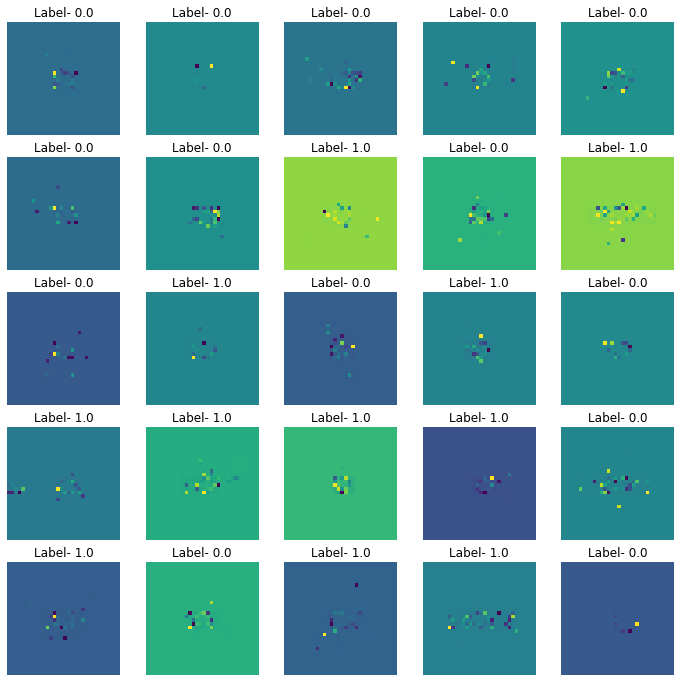

In [12]:
random_idx = np.random.randint(1, len(X_train), size=25)
fig, axes = plt.subplots(5,5, figsize=(12,12))

for idx, ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.set_title(f"Label- {y_train[idx]}")
    ax.imshow(X_train[idx][:,:,1])

In [13]:
data_transforms =transforms.Compose([
            transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
        
        ])

In [14]:
X_train.shape

(338640, 32, 32, 2)

In [15]:
class ML4SCI_Dataset():
  def __init__(self,is_train=True,in_channels=2):
    self.X_train=X_train[:, :, :,:in_channels]
    self.X_test=X_test[:, :, :,:in_channels]
    self.y_train=y_train
    self.y_test=y_test
    self.is_train=is_train
    self.data_transforms=data_transforms
    self.in_channels=in_channels
  def __len__(self):
    if self.is_train:
      return len(self.X_train)
    return len(self.X_test)

  # def __getitem__(self,idx):
  #   if self.is_train:
  #     return (torch.tensor(self.X_train[idx][:,:,0]),torch.tensor(self.y_train[idx],dtype=torch.int))
  #   return (torch.tensor(self.X_valid[idx][:,:,0]),torch.tensor(self.y_valid[idx],dtype=torch.int))
  #   if self.is_train:
  #     return (torch.tensor(self.X_train[idx][:,:,0]),torch.tensor(self.y_train[idx],dtype=torch.int))

  def __getitem__(self,idx):
#     if self.is_train:
#       return (data_transforms(torch.tensor(self.X_train[idx]).view(self.in_channels,32,32)),torch.tensor(self.y_train[idx],dtype=torch.int))
#     return (data_transforms(torch.tensor(self.X_test[idx]).view(self.in_channels,32,32)),torch.tensor(self.y_test[idx],dtype=torch.int))
    if self.is_train:
      return (data_transforms(self.X_train[idx]),torch.tensor(self.y_train[idx],dtype=torch.int))
    return (data_transforms(self.X_test[idx]),torch.tensor(self.y_test[idx],dtype=torch.int))


In [16]:
X_train[0].shape

(32, 32, 2)

In [17]:
train_data=ML4SCI_Dataset(in_channels=2)
valid_data=ML4SCI_Dataset(is_train=False,in_channels=2)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size = 256, shuffle = True)
valid_loader = DataLoader(dataset = valid_data, batch_size = 256, shuffle = True)

In [19]:
m,n=next(iter(train_loader))
m.shape

torch.Size([256, 2, 32, 32])

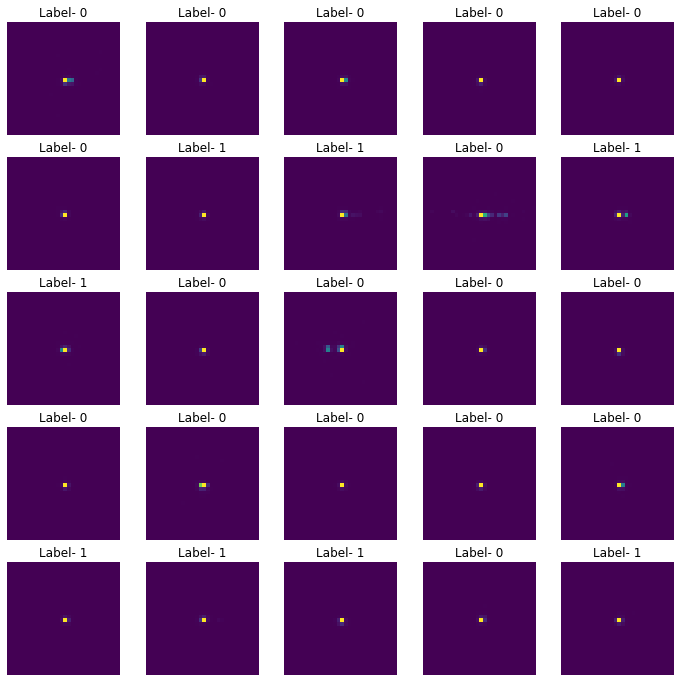

In [20]:
random_idx = np.random.randint(1, len(m), size=25)
fig, axes = plt.subplots(5,5, figsize=(12,12))

for idx, ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.set_title(f"Label- {n[idx]}")
    ax.imshow(m[idx][0])

# Vision transformer from Scratch

In [23]:
! pip install einops

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


In [25]:
# transform = Compose([Resize((224, 224)), ToTensor()])
# x = transform(img)
# x = x.unsqueeze(0) # add batch dim
# x.shape


In [26]:
patch_size = 4 # 16 pixels\

x=torch.randn((1,2,32,32))
# pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)


In [27]:

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 2, patch_size: int = 4, emb_size: int = 128, img_size: int = 32):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape


torch.Size([1, 65, 128])

In [28]:

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 128, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 65, 128])

In [29]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


In [30]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


In [31]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 256,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


In [32]:
# patches_embedded = PatchEmbedding()(x)
# TransformerEncoderBlock()(patches_embedded).shape


In [33]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 128, n_classes: int = 2):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))


In [34]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 1,
                patch_size: int = 4,
                emb_size: int = 128,
                img_size: int = 32,
                depth: int = 12,
                n_classes: int = 1,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        


# Training

In [ ]:
break

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model=ViT(in_channels = 2,patch_size = 8,emb_size = 128,img_size = 32,depth = 12,n_classes = 2).to(device)

In [ ]:
break

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# model=torch.load("/content/drive/MyDrive/Hackathons/ML4SCI/ViT_10-epochs_068-auc.pth")

In [ ]:
batch_size = 256
epochs = 16
lr = 1e-5
gamma = 0.1


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = lr)

scheduler = StepLR(optimizer, step_size=6, gamma=gamma)

In [ ]:
gc.collect()

401

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        #print(label)
        label_oh = torch.nn.functional.one_hot(label.long(), num_classes = 2)
        label_oh = label.type_as(output)
        
        loss = criterion(output, label_oh.long())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        # print(output.argmax(dim=1))
        train_acc = (output.argmax(dim=1) == label).float().mean()
        # epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        a=[]
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            label_oh = torch.nn.functional.one_hot(label.long(), num_classes = 2)

            val_output = model(data)
            label_oh = label.type_as(val_output)
            val_loss = criterion(val_output, label_oh.long())

            y_pred_val=val_output.argmax(dim=1)

            val_acc = (y_pred_val == label).float().mean()
            # epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            fpr,tpr,_=roc_curve(label.cpu(), y_pred_val.cpu())
            a.append(auc(fpr, tpr))
    scheduler.step()  
    l=optimizer.param_groups[0]["lr"]
    
    # wandb.log({"Epoch": epoch+1,"train_loss": epoch_loss, "train_acc":train_acc,"val_loss" :epoch_val_loss, "val_acc":val_acc, "AUC": a, "lr": l})

    print(f"Epoch: {epoch+1} - loss: {epoch_loss:.4f} - acc : {train_acc:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {val_acc: .4f} - AUC: {np.mean(a)} - lr: {l}\n")



  0%|          | 0/1323 [00:00<?, ?it/s]

Epoch: 1 - loss: 0.5722 - acc : 0.7260 - val_loss : 0.5774 - val_acc:  0.7000 - AUC: 0.7036327195375136 - lr: 1e-05



  0%|          | 0/1323 [00:00<?, ?it/s]

Epoch: 2 - loss: 0.5720 - acc : 0.7067 - val_loss : 0.5776 - val_acc:  0.6556 - AUC: 0.7032773743718154 - lr: 1e-05



  0%|          | 0/1323 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model,"ViT_30-epochs_070-auc.pth")

# import shutil
# shutil.move("/content/ViT_10-epochs_068-auc.pth","/content/drive/MyDrive/Hackathons/ML4SCI")

# Evaluation 

In [38]:
model=torch.load("/content/ViT_31-epochs_0713-auc.pth")

In [44]:
a,y_true,y_pred=[],torch.tensor([]),torch.tensor([])
with torch.no_grad():
    for data, label in valid_loader:

        data = data.to(device)
        label = label.to(device)
        label_oh = torch.nn.functional.one_hot(label.long(), num_classes = 2)

        val_output = model(data)
        label_oh = label.type_as(val_output)

        y_pred_val=val_output.argmax(dim=1)

        val_acc = (y_pred_val == label).float().mean()
        y_pred=torch.cat([y_pred.cpu(),val_output[:,1].cpu()],dim=0)
        y_true=torch.cat([y_true.cpu(),label_oh.cpu()],dim=0)
    fpr,tpr,_=roc_curve(y_true,y_pred)


In [45]:
fpr,tpr,_=roc_curve(y_true,y_pred)
print("AUC:",auc(fpr,tpr))

AUC: 0.7676775671872225


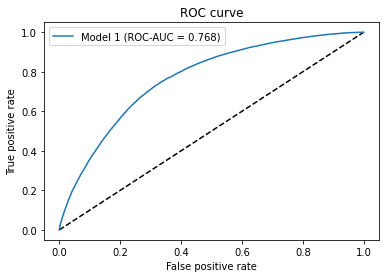

In [47]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(auc(fpr,tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()